## Steps to fine tune model
- Select and load model
- Select and preprocess dataset (train/eval split, tokenize)
- Define quantization or adaptation before fine-tuning for efficiency
- Tune and evaluate model



### Load model

In [1]:
!pip install -q accelerate transformers peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 8.4 MB/s eta 0:00:00


In [2]:
!pip install -q datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00


In [3]:
!pip install -q bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 3.3 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [5]:
import accelerate

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
    # bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", device_map="auto",
                                            #  quantization_config=bnb_config,
                                            #  torch_dtype=torch.float16, load_in_8bit=True,
                                             token=access_token)
# tokenizer = AutoTokenizer.from_pretrai\ned("microsoft/phi-2")#, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/phi-2",
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False
)
tokenizer.pad_token = tokenizer.eos_token


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like microsoft/phi-2 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [6]:
import torch
print(torch.cuda.is_available(), model.device)
model.num_parameters()

True cuda:0


2779683840

In [7]:
import numpy as np
import pandas as pd

def count_trainable_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params
count_trainable_parameters(model)

2779683840

In [8]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [9]:
!nvidia-smi

Wed Feb 28 17:29:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              33W /  70W |  10851MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
inputs = tokenizer("""
  Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
  The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
  Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
  and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
""",
                   return_tensors="pt", return_attention_mask=False).to("cuda")

outputs = model.generate(**inputs, max_length=500)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<|endoftext|>
    Give me an email-only content calendar for activating users that haven't used my service in more than 3 months. 
    The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands. 
    Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users, 
    and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.

1. A monthly newsletter with a list of the most popular houses and apartments in the Netherlands.
2. A weekly blog post with tips on how to find the perfect home in the Netherlands.
3. A monthly webinar with a real estate expert discussing the current housing market in the Netherlands.
4. A monthly social media campaign featuring user-generated content from people who have found their dream home in the Netherlands.
5. A monthly email with a personalized recommendation for a house or apar

In [11]:
# with open('finetune-emails.txt', 'r') as file:
#     text = ''.join([row for row in file.readlines() if row != '\n'])
# with open('sadyr_preprocessed.txt', 'w') as file:
#     file.write(text)

from datasets import load_dataset
dataset = load_dataset(path='text', data_files='finetune-emails.txt', split='train')
dataset = dataset.train_test_split(train_size=0.9)

In [12]:
dataset['train'], dataset['test']

(Dataset({
     features: ['text'],
     num_rows: 30132
 }),
 Dataset({
     features: ['text'],
     num_rows: 3349
 }))

In [13]:
generate_and_tokenize_prompt = lambda prompt: tokenizer(prompt['text'])

tokenized_train_dataset = dataset['train'].map(generate_and_tokenize_prompt)
tokenized_val_dataset = dataset['test'].map(generate_and_tokenize_prompt)

Map:   0%|          | 0/30132 [00:00<?, ? examples/s]

Map:   0%|          | 0/3349 [00:00<?, ? examples/s]

33481


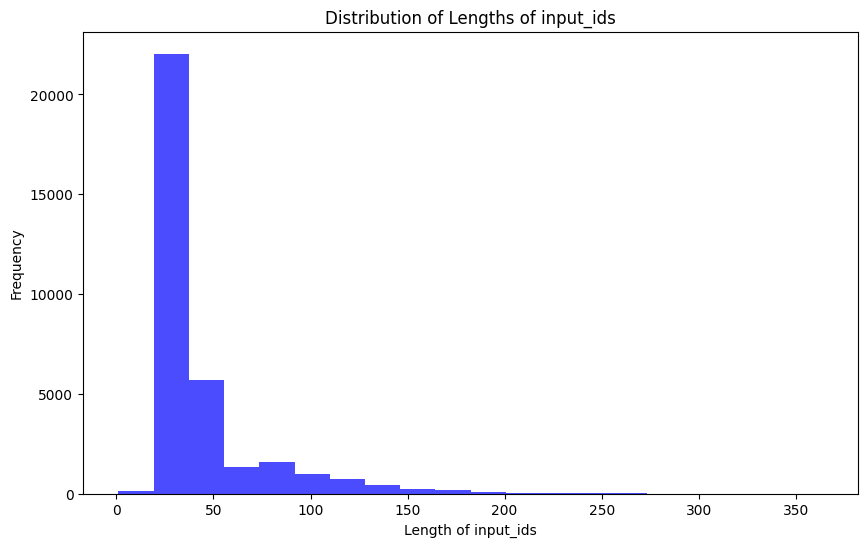

In [14]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)


In [15]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
# model = prepare_model_for_kbit_training(model)


In [16]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2560,),

In [17]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        # "dense",
        "fc1",
        "fc2",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
# print_trainable_parameters(model)


In [18]:
f'trainable params: {100 * count_trainable_parameters(model) / model.num_parameters()}'

'trainable params: 1.4864842795940476'

In [19]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)
model = accelerator.prepare_model(model)


In [20]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True


import transformers
from datetime import datetime

project = "emails"
base_model_name = "phi-2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        # per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        # max_steps=500,
        num_train_epochs=3,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        # bf16=True,
        # fp16=True,
        # optim="paged_adamw_8bit",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        optim="paged_adamw_32bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=1000,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=1000,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        # report_to="wandb",           # Comment this out if you don't want to use weights & baises
        # run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.11 GiB. GPU 0 has a total capacty of 14.75 GiB of which 775.06 MiB is free. Process 75744 has 13.72 GiB memory in use. Of the allocated memory 12.72 GiB is allocated by PyTorch, and 887.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
inputs = tokenizer('Who is Sadyr Zhaparov?',
                   return_tensors="pt", return_attention_mask=False).to("cuda")

outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)